In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import random as rd

## Loading health_data

In [2]:
df_h = pd.read_csv('health_data.csv')
print(df_h.head())

train_per = 0.7 #train test split
#randomize indces, take the first 80% of the indeces and last 20 percent as test
indices = np.random.permutation(df_h.shape[0])
train_ind, test_ind = indices[:int(train_per*df_h.shape[0])], indices[int(train_per*df_h.shape[0]):]
# print(len(train_ind), len(test_ind))

#select the data corresponding to the train and test indices and save into 2 dataframes. Reset index afterwards
train_df, test_df = df_h.loc[train_ind, :], df_h.loc[test_ind, :]
train_df, test_df = train_df.reset_index(drop = True), test_df.reset_index(drop = True)
# train_df.drop('index')

# Data in numpy arrays (also separating train data by classes)
X_train_0, X_train_1 = train_df.loc[train_df['category'] == 0].drop('category', axis = 1).to_numpy(),train_df.loc[train_df['category'] == 1].drop('category', axis = 1).to_numpy()
X_test, y_test = test_df.drop('category', axis = 1).to_numpy(), test_df['category'].to_numpy().reshape((-1, 1))
print(X_train_0.shape, X_train_1.shape, X_test.shape, y_test.shape)

   age  restbps  chol  category
0   26      109   243         0
1   27      106   156         0
2   28      107   225         0
3   27      105   277         0
4   30       96   221         0
(274, 3) (215, 3) (211, 3) (211, 1)


### Data Visualization(PCA/tSNE)

### Some data analysis

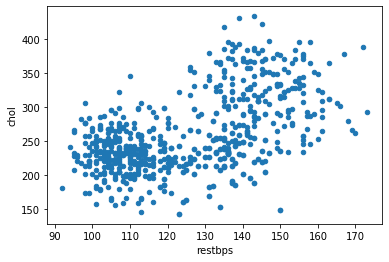

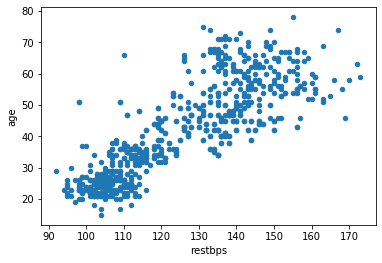

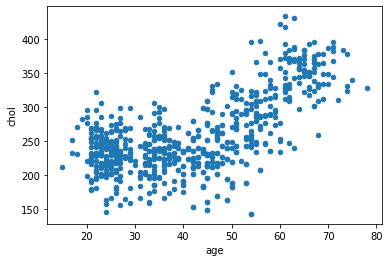

In [42]:
df_h.plot.scatter(x = 'restbps', y = 'chol')
df_h.plot.scatter(x = 'restbps', y = 'age')
df_h.plot.scatter(x = 'age', y = 'chol')

# Naive Bayes Classifier - with Gaussian or some other density functions as density estimates of individual features for a particular class

### MLE

In [47]:
def get_naive_params(X):
    mu = np.mean(X, axis = 0)
    var = np.var(X, axis = 0)
    return {'mu':mu, 'var':var}

def performance_metrics(y_pred_test, y_test):
    '''gives the TPR, FPR, acc, precision, recall and F1 score by comparing the 2 input arrays'''
    #for precision, recall, class 1 will be positive class (ie the person ahs a health condition) 
    #and 0 as negative class (no health condition)
    TP = np.logical_and(y_pred_test==y_test,y_pred_test == 1).sum()
    FP = np.logical_and(y_pred_test!=y_test,y_pred_test == 1).sum()
    TN = np.logical_and(y_pred_test==y_test,y_pred_test == 0).sum()
    FN = np.logical_and(y_pred_test!=y_test,y_pred_test == 0).sum()
    ACC = (TP+TN)/(TP+TN+FP+FN)
    P = (TP)/(TP+FP)
    R = (TP)/(TP+FN)
    F1 = 2*P*R/(P+R)
    TPR = R
    FPR = FP/(FP+TN)
    
    return {'accuracy':ACC, 'precision':P, 'recall':R, 'F1':F1, 'TPR':TPR, 'FPR': FPR}

def getpriors(X_train_0, X_train_1):
    priors = [X_train_0.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0]), X_train_1.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0])]
    return priors

def gaussian_univariate(x, mu, var):
    """ to get the value of pdf having scalar params mu and var, @x """
    diff = (x - mu)
    pdf_x = (1/(np.sqrt(2*np.pi)))* (1/np.sqrt(var)) * (np.exp(-0.5*(diff**2)/(var)))
    return pdf_x.item()

def naive_likelihood(x, mu_array, var_array):
    '''mu_array, and var_array are d dimensional array where d is the size of x which is the number of features'''
    likelihood = 1
    for i in range(x.shape[0]):
        likelihood = likelihood * gaussian_univariate(x[i], mu_array[i], var_array[i])
    
    return likelihood
        
def predict_naive(X_test, threshold, priors, naive_params0, naive_params1):
    y_pred_test = np.zeros((X_test.shape[0], 1))
#     print(thresh)
    for i in range(X_test.shape[0]):
        likelihood_0 = naive_likelihood(X_test[i], naive_params0['mu'], naive_params0['var'])
        likelihood_1 = naive_likelihood(X_test[i], naive_params1['mu'], naive_params1['var'])
        y_pred_test[i] = 1 if ((priors[1]/priors[0])*(likelihood_1/likelihood_0) > threshold) else 0
    return y_pred_test

def ROC_naive(X_test, y_test, priors, params_0, params_1):
    FPR_list = []
    TPR_list = []
    for thresh in [2**i for i in range(-30, -2)]:
        y_pred_test = predict_naive(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
    
    for thresh in np.arange(0.01, 5., 0.1):
        y_pred_test = predict_naive(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    for thresh in [2**i for i in range(4, 10)]:
        y_pred_test = predict_naive(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    plt.plot(FPR_list, TPR_list, label='ROC', linestyle = '-', marker = 'o', color = 'r')
#     plt.plot()
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC curve for binary classification')
    plt.legend()
    plt.show()

### Training

In [53]:
priors_naive = getpriors(X_train_0, X_train_1)
naive_params0 = get_naive_params(X_train_0)
naive_params1 = get_naive_params(X_train_1)

### Testing: Experimenting with different thresholds just to see what comes out

In [51]:
threshold = 0.1
y_pred_naive = predict_naive(X_test, threshold, priors_naive, naive_params0, naive_params1)
perf_metrics = performance_metrics(y_pred_naive, y_test)
print(perf_metrics)

threshold = 1
y_pred_naive = predict_naive(X_test, threshold, priors_naive, naive_params0, naive_params1)
perf_metrics = performance_metrics(y_pred_naive, y_test)
print(perf_metrics)

threshold = 20
y_pred_naive = predict_naive(X_test, threshold, priors_naive, naive_params0, naive_params1)
perf_metrics = performance_metrics(y_pred_naive, y_test)
print(perf_metrics)
### Plotting the ROC


{'accuracy': 0.8151658767772512, 'precision': 0.6982758620689655, 'recall': 0.9529411764705882, 'F1': 0.8059701492537313, 'TPR': 0.9529411764705882, 'FPR': 0.2777777777777778}
{'accuracy': 0.8199052132701422, 'precision': 0.7526881720430108, 'recall': 0.8235294117647058, 'F1': 0.7865168539325843, 'TPR': 0.8235294117647058, 'FPR': 0.18253968253968253}
{'accuracy': 0.8767772511848341, 'precision': 0.927536231884058, 'recall': 0.7529411764705882, 'F1': 0.8311688311688311, 'TPR': 0.7529411764705882, 'FPR': 0.03968253968253968}


### Plotting the ROC

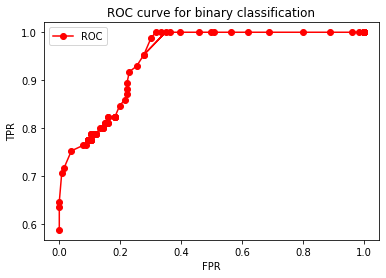

In [52]:
ROC_naive(X_test, y_test, priors_naive, naive_params0, naive_params1)

### MAP

# Bayes Classifier - with (multivariate) Gaussian as class conditional densities

TODO : 1.MLE, 2.MAP

### MLE: 

In [31]:
def gaussian_multivariate(x, mu, sigma):
    """ to get the value of pdf having params mu and sigma, @x """
    dim = len(x)
    diff = (x - mu).reshape((-1,1))
    pdf_x = (1/((np.sqrt(2*np.pi))**dim))* (1/np.sqrt(np.linalg.det(sigma))) * (np.exp(-0.5*(diff.T).dot(np.linalg.inv(sigma).dot(diff))))
    return pdf_x.item()

def get_normal(X):
    mu = np.mean(X, axis = 0)
    sigma = np.cov(X.T)
    return {'mu':mu, 'sigma':sigma}
    
def predict_normal(X_test, threshold, priors, norm_params0, norm_params1):
    y_pred_test = np.zeros((X_test.shape[0], 1))
#     print(thresh)
    for i in range(X_test.shape[0]):
        likelihood_0 = gaussian_multivariate(X_test[i], norm_params0['mu'], norm_params0['sigma'])
        likelihood_1 = gaussian_multivariate(X_test[i], norm_params1['mu'], norm_params1['sigma'])
        y_pred_test[i] = 1 if ((priors[1]/priors[0])*(likelihood_1/likelihood_0) > threshold) else 0
    return y_pred_test

def ROC_gaussian(X_test, y_test, priors, params_0, params_1):
    FPR_list = []
    TPR_list = []
    for thresh in [2**i for i in range(-30, -2)]:
        y_pred_test = predict_normal(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
    
    for thresh in np.arange(0.01, 5., 0.1):
        y_pred_test = predict_normal(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    for thresh in [2**i for i in range(4, 10)]:
        y_pred_test = predict_normal(X_test, thresh, priors, params_0, params_1)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    plt.plot(FPR_list, TPR_list, label='ROC', linestyle = '-', marker = 'o', color = 'r')
#     plt.plot()
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC curve for binary classification')
    plt.legend()
    plt.show()

In [18]:
priors_binary = getpriors(X_train_0, X_train_1)
norm_params0 = get_normal(X_train_0)
norm_params1 = get_normal(X_train_1)

### Experimenting with different thresholds just to see what comes out

In [19]:
threshold = 0.1
y_pred_normal = predict_normal(X_test, threshold, priors_binary, norm_params0, norm_params1)
perf_metrics = performance_metrics(y_pred_normal, y_test)
print(perf_metrics)

threshold = 1
y_pred_normal = predict_normal(X_test, threshold, priors_binary, norm_params0, norm_params1)
perf_metrics = performance_metrics(y_pred_normal, y_test)
print(perf_metrics)

threshold = 20
y_pred_normal = predict_normal(X_test, threshold, priors_binary, norm_params0, norm_params1)
perf_metrics = performance_metrics(y_pred_normal, y_test)
print(perf_metrics)

{'accuracy': 0.8767772511848341, 'precision': 0.7807017543859649, 'recall': 0.9888888888888889, 'F1': 0.8725490196078431, 'TPR': 0.9888888888888889, 'FPR': 0.2066115702479339}
{'accuracy': 0.8909952606635071, 'precision': 0.9036144578313253, 'recall': 0.8333333333333334, 'F1': 0.8670520231213873, 'TPR': 0.8333333333333334, 'FPR': 0.06611570247933884}
{'accuracy': 0.8388625592417062, 'precision': 1.0, 'recall': 0.6222222222222222, 'F1': 0.7671232876712328, 'TPR': 0.6222222222222222, 'FPR': 0.0}


### Plotting the ROC

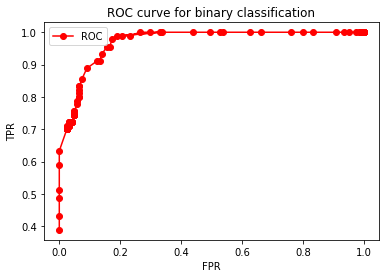

In [21]:
ROC_gaussian(X_test, y_test, priors_binary, norm_params0, norm_params1)

### MAP

# Bayes Classifier - with GMM as class conditional densities

### Useful functions (EM algorithm and other functions for support)

In [22]:
def random_params(k, data):
    pi = np.ones(k)*(1.0/k)
    cols = data.shape[1]
    mu = np.zeros((k, cols))    #mean of k clusters
    for k_ in range(k):
        randnum = np.floor(np.random.random()*len(data))
        for col in range(cols):
            mu[k_][col] += (data[int(randnum)][col])
    
    sigma = []
    #Initializing sigma as covariance of data only for all gaussians
    for i in range(k):
        sigma.append(np.cov(data.T))
    sigma = np.array(sigma)
    
    return pi, mu, sigma


def likelihood(x, pi, mu, sigma, k):
    sum = 0.
    for k_ in range(k):
        sum += pi[k_]*gaussian_multivariate(x, mu[k_], sigma[k_])
    
    return sum.item()

                
def Estep(pi, mu, sigma, k, data):
    N = data.shape[0]
    mem_wts = np.zeros((N, k))
    #storing member weights in an N*k matrix
    for k_ in range(k):
        for n in range(N):
            mem_wts[n,k_] = pi[k_]*gaussian_multivariate(data[n], mu[k_], sigma[k_])/(likelihood(data[n], pi, mu, sigma, k))      
                
    return mem_wts

def Mstep(mem_wts, k, data):
    N = data.shape[0]
    columns = data.shape[1]    
    mu = np.zeros((k, columns))
    sigma = np.zeros((k, columns, columns))
    pi = np.zeros(k)
    for k_ in range(k):
        mem_wts_k_ = mem_wts[:,k_].reshape(N, 1)
        Nk_ = mem_wts_k_.sum()
        pi[k_] = (Nk_)/N
        mu[k_] = (1/Nk_)*(((mem_wts_k_.T).dot(data)).sum(axis=0))
    
    for k_ in range(k):
        mem_wts_k_ = mem_wts[:,k_].reshape(N, 1)
        Nk_ = mem_wts_k_.sum()
        for n in range(N):
            diff = (data[n] - mu[k_]).reshape((-1,1))
            sigma[k_] += (mem_wts_k_[n,0])*(diff.dot(diff.T))
        sigma[k_] /= Nk_
        assert(sigma[k_].shape==(columns,columns))
                
    return pi, mu, sigma

def log_lik(pi, mu, sigma, k, data):
    log_lik = 0.
    
    for n in range(data.shape[0]):
#         print(likelihood(data[n], pi, mu, sigma, k))
        log_lik += np.log(likelihood(data[n], pi, mu, sigma, k))
    return log_lik

def EM(data, k, thresh, iter_max):
#     initialize array - pi, mu, sigmas having parameters for all the gaussians (k in number)
#     print(data[1].shape)
    pi, mu, sigma = random_params(k, data)
    log_lik_list = []
    log_lik_curr = log_lik(pi, mu, sigma, k, data)
    
    for i in range(iter_max):
        log_lik_list.append(log_lik_curr)
        if(i%10 == 0):
            print("iteration     |    {}    |     LogLikelihood = {}".format(i, log_lik_curr))
        mem_wts = Estep(pi, mu, sigma, k, data) #membership weights calculated in the E step
        pi, mu, sigma = Mstep(mem_wts, k, data) #used the membership weights to get new pi, mu, sigma
        
        #calculate new log likelihood
        log_lik_new = log_lik(pi, mu, sigma, k, data)
        
#         check if model has converged
        if(abs(log_lik_new-log_lik_curr) < thresh):
            break
        
        #update log likelihood
        log_lik_curr = log_lik_new
    
    print("EM completed")
    plt.plot(log_lik_list)
    plt.ylabel('Log_Likelihood')
    plt.xlabel('Iterations')
    plt.title('Log_likelihood vs number of iterations in EM algorithm')
    plt.show()
    print('Final log likelihood = {}'.format(log_lik_curr))
    return {'pi':pi, 'mu':mu, 'sigma':sigma}

### Modelling Class conditional densities as Sum of 4 gaussians

iteration     |    0    |     LogLikelihood = -3422.6995487734825
iteration     |    10    |     LogLikelihood = -3258.218281107675
iteration     |    20    |     LogLikelihood = -3253.5194730706276
iteration     |    30    |     LogLikelihood = -3252.7692153428097
iteration     |    40    |     LogLikelihood = -3252.4649169606955
iteration     |    50    |     LogLikelihood = -3251.846303130189
iteration     |    60    |     LogLikelihood = -3251.5757598604305
iteration     |    70    |     LogLikelihood = -3251.4268811188613
iteration     |    80    |     LogLikelihood = -3251.2892701998007
iteration     |    90    |     LogLikelihood = -3251.1028398479552
EM completed


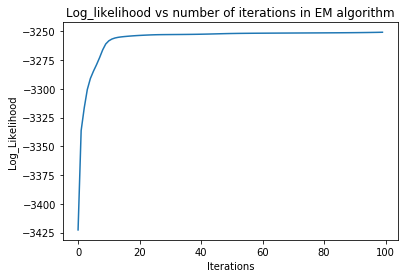

Final log likelihood = -3250.689125072948
iteration     |    0    |     LogLikelihood = -2702.7314672983293
iteration     |    10    |     LogLikelihood = -2640.634086685038
iteration     |    20    |     LogLikelihood = -2624.3792606001643
iteration     |    30    |     LogLikelihood = -2623.4911683886876
iteration     |    40    |     LogLikelihood = -2621.4949691114757
iteration     |    50    |     LogLikelihood = -2619.685597517063
iteration     |    60    |     LogLikelihood = -2619.5493862254534
iteration     |    70    |     LogLikelihood = -2619.1706909755167
iteration     |    80    |     LogLikelihood = -2618.79911692961
iteration     |    90    |     LogLikelihood = -2618.697882038755
EM completed


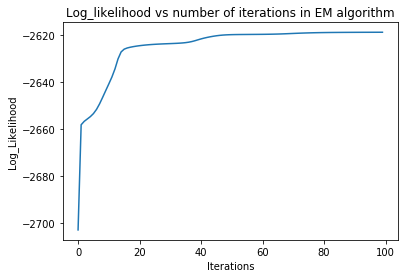

Final log likelihood = -2618.6585651327186


In [23]:
# for classifying test data we first model all the classes of the train data
# let us have data corresponding to 2 classes - data1 and data2
num_gauss = 4 #number of gaussians to model the data
thresh = 0.0001
iter_max = 100
gmm_params_0 = EM(X_train_0, num_gauss, thresh, iter_max)
gmm_params_1 = EM(X_train_1, num_gauss, thresh, iter_max)

### Some more helpful funcions to calculate performance of the model

In [24]:
def prediction_binary(X_test, thresh, priors, gmm_params_0, gmm_params_1, num_gauss):
    y_pred_test = np.zeros((X_test.shape[0], 1))
#     print(thresh)
    for i in range(X_test.shape[0]):
        likelihood_0 = likelihood(X_test[i], gmm_params_0['pi'], gmm_params_0['mu'], gmm_params_0['sigma'], num_gauss)
        likelihood_1 = likelihood(X_test[i], gmm_params_1['pi'], gmm_params_1['mu'], gmm_params_1['sigma'], num_gauss)
#         print((priors[0]/priors[1])*(likelihood_0/likelihood_1))
#         print(thresh)
        y_pred_test[i] = 1 if ((priors[1]/priors[0])*(likelihood_1/likelihood_0) > thresh) else 0
    return y_pred_test

def ROC_GMM(X_test, y_test, priors, gmm_params_0, gmm_params_1):
    FPR_list = []
    TPR_list = []
    for thresh in [2**i for i in range(-30, -2)]:
#     for thresh in range(1,1000):
#         print(thresh)
        y_pred_test = prediction_binary(X_test, thresh, priors, gmm_params_0, gmm_params_1, num_gauss)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
    
    for thresh in np.arange(0.01, 5., 0.1):
#     for thresh in range(1,1000):
#         print(thresh)
        y_pred_test = prediction_binary(X_test, thresh, priors, gmm_params_0, gmm_params_1, num_gauss)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    for thresh in [2**i for i in range(4, 10)]:
#     for thresh in range(1,1000):
#         print(thresh)
        y_pred_test = prediction_binary(X_test, thresh, priors, gmm_params_0, gmm_params_1, num_gauss)
        performance = performance_metrics(y_pred_test, y_test)
        FPR_list.append(performance['FPR'])
        TPR_list.append(performance['TPR'])
        
    plt.plot(FPR_list, TPR_list, label='ROC', linestyle = '-', marker = 'o', color = 'r')
#     plt.plot()
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC curve for binary classification')
    plt.legend()
    plt.show()

## Performance of GMM

### Experimenting with different thresholds just to see what comes out

In [25]:
threshold = 0.1
priors = [X_train_0.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0]), X_train_1.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0])]
y_pred_test = prediction_binary(X_test, threshold, priors, gmm_params_0, gmm_params_1, num_gauss)
perf_metrics = performance_metrics(y_pred_test, y_test)
print(perf_metrics)

threshold = 1
priors = [X_train_0.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0]), X_train_1.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0])]
y_pred_test = prediction_binary(X_test, threshold, priors, gmm_params_0, gmm_params_1, num_gauss)
perf_metrics = performance_metrics(y_pred_test, y_test)
print(perf_metrics)

threshold = 20
priors = [X_train_0.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0]), X_train_1.shape[0]/(X_train_1.shape[0] + X_train_0.shape[0])]
y_pred_test = prediction_binary(X_test, threshold, priors, gmm_params_0, gmm_params_1, num_gauss)
perf_metrics = performance_metrics(y_pred_test, y_test)
print(perf_metrics)

{'accuracy': 0.8815165876777251, 'precision': 0.782608695652174, 'recall': 1.0, 'F1': 0.878048780487805, 'TPR': 1.0, 'FPR': 0.2066115702479339}
{'accuracy': 0.8767772511848341, 'precision': 0.8478260869565217, 'recall': 0.8666666666666667, 'F1': 0.8571428571428571, 'TPR': 0.8666666666666667, 'FPR': 0.11570247933884298}
{'accuracy': 0.8151658767772512, 'precision': 1.0, 'recall': 0.5666666666666667, 'F1': 0.7234042553191489, 'TPR': 0.5666666666666667, 'FPR': 0.0}


### Plotting the ROC

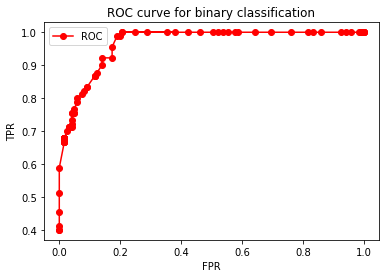

In [26]:
ROC_GMM(X_test, y_test, priors, gmm_params_0, gmm_params_1)


# Parzen
### Window functions - euclidean distance, gaussian

# KNN

# Linear Models
### Logistic classifier, Linear(?) classifier - L2,L1,Elastic Net
### GLM ie Logistic with sigma(phi(W.TX))- Different Kernels, L2,L1, Elastic